# Prerequisites

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import pandas as pd
from scipy import stats
import pickle
import pprint 

%matplotlib inline

# Set the tensorflowHub cache directory path:

In [2]:
!export TFHUB_CACHE_DIR='./MODEL_CACHE'

## Load and/or download ProGAN model from tensorflowHub

In [3]:
MODEL_PATH  = "https://tfhub.dev/google/progan-128/1"
signature = None

tf.logging.set_verbosity(tf.logging.ERROR)

G = hub.Module(MODEL_PATH, trainable=False)

# Load  pre-computed out-domain latent vectors for ProGAN:

In [4]:
OUTDOMAIN_LV_PATH = 'DATA/odlv_for_ProGAN.pickle'

with open(OUTDOMAIN_LV_PATH, 'rb') as f:
    odlvs, xtarget = pickle.load(f) 

# Validate Out-domain latent vector stats
## ProGAN has a latent prior distribution $\mathcal{N}(0, I)$ with moment

In [5]:
MAX_MOMENTS = 4
ns = stats.norm(0, 1)
ns_ms = {"m%d" % i : ns.moment(i) for i in range(1, MAX_MOMENTS+1)}

print('Target moments:')
pprint.pprint(ns_ms, width=10)

Target moments:
{'m1': 0.0,
 'm2': 1.0,
 'm3': 0.0,
 'm4': 3.0}


### Moments and test evaluation on Out-domain latent vectors:

In [6]:
moments = {"m%d" % i : stats.moment(odlvs, i, 1) for i in range(1, MAX_MOMENTS+1)}
tests_pval = [stats.anderson(odlv)[0] for odlv in odlvs]

df = pd.DataFrame(moments)
df['Anderson-Darling test pvalue'] = tests_pval
df

,m1,m2,m3,m4,Anderson-Darling test pvalue
0,0.0,1.000022,0.000026,3.000145,0.282818
1,0.0,0.999996,-0.000005,2.999985,0.238862
2,0.0,0.999993,0.000033,2.999828,0.234674
3,0.0,1.000088,-0.000174,3.000574,0.287217
4,0.0,1.000006,-0.000002,3.000021,0.379138
5,0.0,0.999998,-0.000035,2.999993,0.160260
6,0.0,1.000086,-0.000132,3.000197,0.269199
7,0.0,1.000019,-0.000082,3.000220,0.297399
8,0.0,1.000062,-0.000021,3.000451,0.197747
9,0.0,1.000046,-0.000065,3.000234,0.734253


# Generate Out-domain examples from the Generator:

In [7]:
n, m = odlvs.shape

z_rand = np.random.normal(size=(n, m))

z = tf.placeholder( shape=(None, m), dtype=tf.float32)
x = G(z, signature=signature)
        
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
    
with tf.Session(config=config) as sess:
    sess.run( tf.global_variables_initializer() )
    
    odes_x = sess.run(x, {z:odlvs})
    normal_x = sess.run(x, {z:z_rand})

## Plot out-domain examples and target images

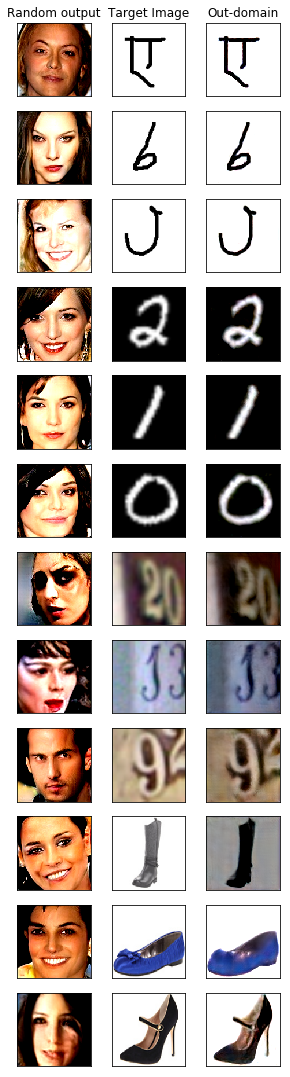

In [21]:
PSIZE = 1.6
fig, ax = plt.subplots(n, 3, figsize=(3*PSIZE, n*PSIZE))

ax[0, 0].set(title='Random output')
ax[0, 1].set(title='Target Image')
ax[0, 2].set(title='Out-domain')

for i in range(n):
    ax[i, 0].imshow(normal_x[i]);
    ax[i, 0].set(xticks=[], yticks=[])
    
    ax[i, 1].imshow(xtarget[i]);
    ax[i, 1].set(xticks=[], yticks=[])
    
    ax[i, 2].imshow(odes_x[i]); 
    ax[i, 2].set(xticks=[], yticks=[])   

## Linear interpolation with a out-domain latent vector:

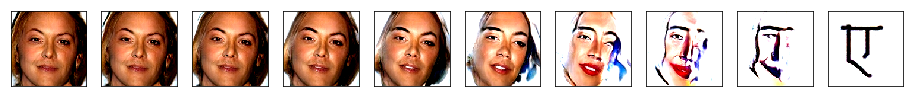

In [22]:
# Chose instances to intorpolate
si, ei = 0, 0 


def linearInterpolation(x, y, n):
    alpha = np.linspace(0, 1, n)[:, np.newaxis]
    z = y * alpha + x * (1 - alpha)
    return z

n_steps = 10

start = z_rand[si]
end = odlvs[ei]

z_inter = linearInterpolation(start, end, n_steps)

with tf.Session(config=config) as sess:
    sess.run( tf.global_variables_initializer() )
    
    x_inter = sess.run(x, {z:z_inter})
    

# plot
    
fig, ax = plt.subplots(1, n_steps, figsize=(n_steps*PSIZE, PSIZE))

for i in range(n_steps):
    ax[i].imshow(x_inter[i]);
    ax[i].set(xticks=[], yticks=[]);